In [1]:
!pip install -qq transformers
!pip install -qq sentencepiece
!pip install -qq datasets


     |████████████████████████████████| 3.5 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 63.2 MB/s 
     |████████████████████████████████| 6.5 MB 46.0 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 
     |████████████████████████████████| 1.2 MB 4.3 MB/s 
     |████████████████████████████████| 311 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 72.0 MB/s 
     |████████████████████████████████| 212 kB 78.1 MB/s 
     |████████████████████████████████| 134 kB 53.2 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 68.3 MB/s 
     |████████████████████████████████| 144 kB 41.3 MB/s 


In [2]:
import transformers
import datasets
from transformers import AutoTokenizer
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random
from datasets import load_from_disk, concatenate_datasets
from datasets import Dataset, DatasetDict

In [3]:
from torch import nn
import matplotlib.pyplot as plt

In [4]:
# The names of the BERT and DistilBERT models used for Tokenization
DISTILBERT_MODEL_NAME = "distilbert-base-uncased"
BERT_MODEL_NAME = "bert-base-uncased"


In [5]:
twitter_ds = load_from_disk('/content/drive/MyDrive/Dissertation/twitter_ros_dfs.csv')
hatexplain_ds = load_from_disk('/content/drive/MyDrive/Dissertation/hateexplain_merged_ds')

In [6]:
print("Twitter Columns:" ,", ".join(twitter_ds.column_names))
print("HateXplain Columns:" ,", ".join(hatexplain_ds.column_names))

Twitter Columns: label, sentence
HateXplain Columns: id, annotators, rationales, post_tokens, label, votes, sentence, token_count, target


In [7]:
hatexplain_ds = hatexplain_ds.remove_columns(["id", "annotators", "rationales", "post_tokens", "votes", "token_count", "target"])

In [8]:
hatetwit_ds = concatenate_datasets([twitter_ds,hatexplain_ds])

In [9]:
distilbert_tokenizer = AutoTokenizer.from_pretrained(DISTILBERT_MODEL_NAME)
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [10]:
tokenized_data = bert_tokenizer(hatetwit_ds["sentence"])

In [11]:
token_lengths = []
for row in tokenized_data.data["input_ids"]:
  token_lengths.append(len(row))

token_lengths.sort(reverse =True)  




In [12]:
datasize = len(token_lengths)
count_128  = len( list( filter(lambda length: length > 128, token_lengths) ))
count_64  = len( list( filter(lambda length: length > 64, token_lengths) ))
count_32  = len( list( filter(lambda length: length > 32, token_lengths) ))
count_16  = len( list( filter(lambda length: length > 16, token_lengths) ))
print("# Length > 128: ", count_128, " Percentage = " ,(count_128/datasize) * 100)
print("# Length > 64: ", count_64, " Percentage = ", (count_64/datasize) * 100)
print("# Length > 32: ", count_32, " Percentage = " ,(count_32/datasize) * 100)
print("# Length > 16: ", count_16, " Percentage = " ,(count_16/datasize) * 100)

# Length > 128:  18  Percentage =  0.038641535357004854
# Length > 64:  439  Percentage =  0.9424241123180627
# Length > 32:  11818  Percentage =  25.370314713837967
# Length > 16:  32919  Percentage =  70.66892791206904


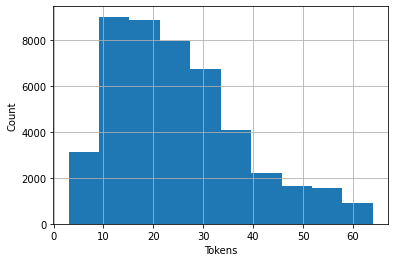

In [13]:
plt.figure()
plt.hist(list( filter(lambda length: length <= 64, token_lengths)), label ="Tokens")
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [14]:
MAX_LENGTH=64

In [15]:
def bert_tokenize_function(examples):
    return bert_tokenizer(examples["sentence"], max_length=MAX_LENGTH, truncation=True, padding="max_length")

def distilbert_tokenize_function(examples):
    return distilbert_tokenizer(examples["sentence"], max_length=MAX_LENGTH, truncation=True, padding="max_length")




In [16]:
tokenized_datasets_bert = hatetwit_ds.map(bert_tokenize_function, batched=True)

  0%|          | 0/47 [00:00<?, ?ba/s]

In [17]:
tokenized_datasets_bert

Dataset({
    features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46582
})

In [18]:
tokenized_datasets_bert = tokenized_datasets_bert.rename_column("input_ids", "input_ids_bert")
tokenized_datasets_bert = tokenized_datasets_bert.rename_column("attention_mask", "attention_mask_bert")
tokenized_datasets_bert = tokenized_datasets_bert.rename_column("token_type_ids", "token_type_ids_bert")

In [19]:
tokenized_datasets_distbert_bert = tokenized_datasets_bert.map(distilbert_tokenize_function, batched=True)

  0%|          | 0/47 [00:00<?, ?ba/s]

In [20]:
tokenized_datasets_distbert_bert.filter

Dataset({
    features: ['label', 'sentence', 'input_ids_bert', 'token_type_ids_bert', 'attention_mask_bert', 'input_ids', 'attention_mask'],
    num_rows: 46582
})

In [23]:
hate  = len(tokenized_datasets_distbert_bert.filter(lambda example: example['label']==0 ))
offensive  = len(tokenized_datasets_distbert_bert.filter(lambda example: example['label']==1 ))
normal  = len(tokenized_datasets_distbert_bert.filter(lambda example: example['label']==2 ))
print("# Hate", hate, " Percentage = " ,(hate/datasize) * 100)
print("# Offensive", offensive, " Percentage = " ,(offensive/datasize) * 100)
print("# Normal", normal, " Percentage = " ,(normal/datasize) * 100)

Loading cached processed dataset at /content/drive/MyDrive/Dissertation/twitter_ros_dfs.csv/cache-85d4de2df9edcaf6.arrow
Loading cached processed dataset at /content/drive/MyDrive/Dissertation/twitter_ros_dfs.csv/cache-a54f856e522e6ac5.arrow
Loading cached processed dataset at /content/drive/MyDrive/Dissertation/twitter_ros_dfs.csv/cache-edc5ce0869ac78a3.arrow


# Hate 9935  Percentage =  21.3279807651024
# Offensive 24670  Percentage =  52.960370958739425
# Normal 11977  Percentage =  25.711648276158172


In [ ]:
for i in range(1,11):
  train_data, test_valdata = train_test_split(tokenized_datasets_distbert_bert,train_size=0.8, test_size =0.2, shuffle=True, stratify=tokenized_datasets_distbert_bert['label'])
  train_data = pd.DataFrame(train_data)
  test_valdata = pd.DataFrame(test_valdata)
  test_data, val_data = train_test_split(test_valdata ,train_size=0.5, test_size =0.5,  stratify=test_valdata['label'])
  hatetwit_dict  = DatasetDict({"train": Dataset.from_pandas(train_data), "test": Dataset.from_pandas(test_data), "validation": Dataset.from_pandas(val_data)})
  hatetwit_dict.save_to_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))

